# Imports

In [1]:
import pandas as pd

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import neighbors, datasets
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.metrics import accuracy_score 
import plot_utils
from statistics import mean 

# Read Data Set

In [2]:
df = pd.read_csv("featured_data_with_fixed_time.csv")
df = df.drop('total_time', axis=1, errors='ignore') 
df = df.drop('session_id', axis=1, errors='ignore') 
df = df.drop('scenario', axis=1, errors='ignore') 
df = df.drop('pedId', axis=1, errors='ignore') 
df = df.drop('speed_react', axis=1, errors='ignore') 
df = df.drop('distancePed', axis=1, errors='ignore') 
df = df.drop('speed_react', axis=1, errors='ignore') 
df = df.drop('reaction_time', axis=1, errors='ignore') 
df = df.drop('pedestriansLevel', axis=1, errors='ignore') 
df = df.drop('visibilityLevel', axis=1, errors='ignore') 
df = df.drop('trafficLevel', axis=1, errors='ignore') 

pd.options.display.max_columns = None
df.head()

,speed_total_mean,steering_total_mean,brake_total_mean,throttle_total_mean,acceleration_total_mean,speed_total_var,steering_total_var,brake_total_var,throttle_total_var,acceleration_total_var,max_speed,PKE,PKE_Steering,hadCollision
0,6.978462,0.493644,0.947244,0.813465,-0.000623,13.607109,0.000420,0.021339,0.032907,0.050404,11.669766,1.105975,-1.848506e+06,0
1,7.045599,0.504890,0.875541,0.911211,-0.045255,33.663919,0.000176,0.065360,0.002429,0.068962,13.499710,0.077727,0.000000e+00,0
2,10.263041,0.478319,0.817679,0.595013,-0.017068,76.873997,0.001610,0.105119,0.076302,0.705761,25.851397,5.013003,6.996196e+05,1
3,7.264644,0.514681,0.801175,0.653184,-0.039171,54.852313,0.000417,0.031045,0.038022,0.079587,20.067612,4.199223,-2.257110e+06,1
4,9.494161,0.505996,0.653854,0.808684,-0.143883,87.900514,0.000130,0.106531,0.056698,0.141090,29.754023,1.505738,7.974151e+05,1


### Context

The data source is created from "thesis_molding_fixed_time.ipynb" from the initial data set of GTA, Driving simulator and demographic data.

&nbsp; Each row cames from every pedestrian that driver cross. So we have many rows for every scenario (depending on how many pedestrians where in that scenario) and many scenarios from every driver (there are 5 scenarios). 
    
&nbsp; We took a previous fixed period of time of every pedestrian (taking a tail of rows from the initial data set of every pedestrian identified) and having as the target feature the result of the collision between the car and the pedestrian.

The columns in this merged data are:
- **index**
- **pedId**: id from the pedestrian crossed
- **speed_total_mean**: mean from speed collected from GTA game in that period of time
- **steering_total_mean**: mean from steering wheel from Driving simulator in that period of time
- **brake_total_mean**: mean from brake pedal from Driving simulator in that period of time
- **throttle_total_mean**: mean from throttle pedal from Driving simulator in that period of time
- **acceleration_total_mean**: mean from acceleration collected from GTA game
- **speed_total_var**: variance from speed collected from GTA game
- **steering_total_var**: variance from steering wheel from Driving simulator
- **brake_total_var**: variance from brake pedal from Driving simulator
- **throttle_total_var**: variance from throttle pedal from Driving simulator
- **acceleration_total_var**: variance from acceleration collected from GTA game
- ~~**total_time**: time in seconds of that period of time (can be different because some pedestrians appear quickly or some drivers where stopped on a traffic light).~~
- **distancePed**: idstance between the driver and the pedestrian when the pedestrian started running
- **max_speed**: max speed in that period of time
- **PKE**: Agressive driving measure considering drastic movements of speed 
- **PKE_steering**: Agressive driving measure considering drastic movements of steering
- **speed_react**: Actual speed when pedestrian start crossing
- **reaction_time**: time in seconds from when the pedestrian started running until there was a reaction in the driver's brake pedal
- **pedestrianLevel**: Level of pedestrians in that scenario as integer ( {0: Low, 1: Normal, 2: High} )
- **visibilityLevel**: Level of visibility in that scenario as integer ( {0: Low, 1: High})
- **trafficLevel**: Level of traffic in that scenario as integer ( {0: Low, 1: High})
- ~~**gender**: gender of the driver {'Male': 0, 'Female': 1}~~
- ~~**age**: Age of driver~~
- ~~**job**: job of the driver {'Student': 0, 'PhD Student': 1, 'Researcher': 2, 'Project Coordinator': 3, 'Research Associate': 4, 'PA': 5, 'Events': 6}~~
- ~~**LatestDegree**: Last degree of the driver {'Bachelor': 0, 'Master': 1, 'PhD': 2, 'High School': 3, 'Uni Diploma': 4, 'University': 5}~~
- ~~**OftenDrive**: level from 1 to 5.~~
- ~~**accidents**: number of accidents in the past~~
- ~~**yearsDriving**: years driving~~
- ~~**lastDrive**: last drive (in years)~~
- ~~**speedingTickets**: speeding tickets receive in the past~~
- **hadCollision**: False: 0, True: 1
    
The differents scenario were:
- Scenario 1 : Low pedestrian    | High Visibility | Low Traffic
- Scenario 2 : High pedestrian   | High Visibility | Low Traffic
- Scenario 3 : Normal pedestrian | Low Visibility  | Low Traffic
- Scenario 4 : Normal pedestrian | High Visibility | Low Traffic 
- Scenario 6 : Normal pedestrian | High Visibility | High Traffic 
    

### Distribution of cases

In [3]:
num_obs = len(df)
num_true = len(df.loc[df['hadCollision'] == 1])
num_false = len(df.loc[df['hadCollision'] == 0])
print("Number of True cases:  {0} ({1:2.2f}%)".format(num_true, (num_true/num_obs) * 100))
print("Number of False cases: {0} ({1:2.2f}%)".format(num_false, (num_false/num_obs) * 100))

Number of True cases:  34 (7.49%)
Number of False cases: 420 (92.51%)


We have considerably more false cases than true ones.

### Understanding features

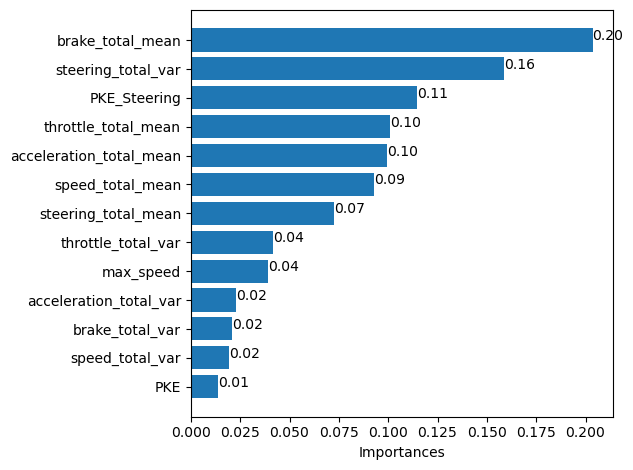

In [4]:
from sklearn.tree import DecisionTreeClassifier
data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

classifier = DecisionTreeClassifier()
classifier.fit(X, Y)

list_importances = []
for i in range(1000):
    classifier = DecisionTreeClassifier()
    classifier.fit(X, Y)
    list_importances.append(classifier.feature_importances_)
    

    
np_list = np.array(list_importances)    

importances_zip = zip(X.columns, np.average(np_list, axis=0))
importances_sorted = sorted(importances_zip, key=lambda tup: tup[1], reverse=True)
columns = []
importances = []
for name, importance in importances_sorted:
    columns.append(name)
    importances.append(importance)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(columns, importances, align='center')
for index,value in enumerate(importances):
    ax.text(value, index, str("{:.2f}".format(value)))

ax.set_yticks(X.columns)
ax.set_yticklabels(X.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importances')
fig.tight_layout()

plt.show()

Regarding this decision tree we can see that only 14 of 30 of the features has at least some of importance in order to predict if the driver will have a collision.

All scenario data seems to be less important, and also almost all of demographic data seems to be the same (perhaps here there is a failure when grouping the data).

The most importante feature is the brake pedal mean and also we have in third and sixth place the reaction time and breke pedal variance which is logic.

The initial distance with the pedestrian is also in second place so this can be some clue that the driver has or not a long time driving in order to discover the influence of possible distractions.

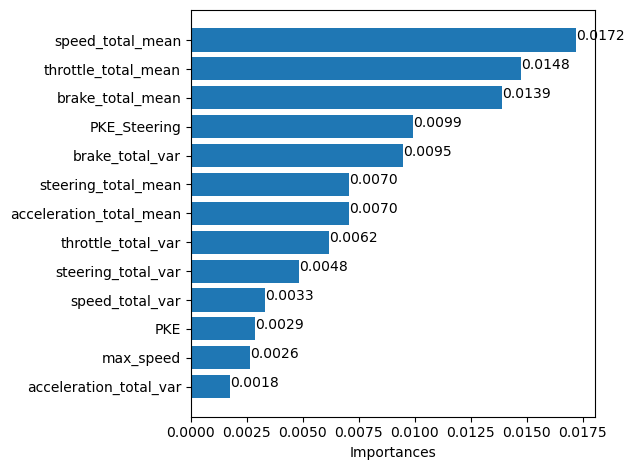

In [5]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

data = df.copy()
X = data.drop('hadCollision', axis=1) 
Y = data['hadCollision']

rf_model = RandomForestClassifier()
rf_model.fit(X, Y)

result = permutation_importance(rf_model, X, Y, n_repeats=10, random_state=0)

list_importances = []
for i in range(10):
    rf_model = RandomForestClassifier()
    rf_model.fit(X, Y)
    result = permutation_importance(rf_model, X, Y, n_repeats=10, random_state=0)
    list_importances.append(result.importances_mean)
    

    
np_list = np.array(list_importances)    

importances_zip = zip(X.columns, np.average(np_list, axis=0))

importances_zip = zip(X.columns, result.importances_mean)
importances_sorted = sorted(importances_zip, key=lambda tup: tup[1], reverse=True)
columns = []
importances = []
for name, importance in importances_sorted:
    columns.append(name)
    importances.append(importance)

plt.rcdefaults()
fig, ax = plt.subplots()

ax.barh(columns, importances, align='center')
for index,value in enumerate(importances):
    ax.text(value, index, str("{:.4f}".format(value)))

ax.set_yticks(X.columns)
ax.set_yticklabels(X.columns)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importances')
fig.tight_layout()

plt.show()